<a href="https://colab.research.google.com/github/deniskaanikov/ML/blob/main/%D0%BB%D0%B0%D0%B1_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Создание нейронной сети для решения задачи регрессии

Часть 1. Создание слоя нормализации для масштабирования входных данных

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Кол-во знаков после запятой будет 3 при построении графиков
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.17.0


In [ ]:
#импорт данных, заполнение пустых значений
url='http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names=['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model_Year', 'Origin']

raw_dataset=pd.read_csv(url, names=column_names,
                        na_values='?', comment='\t',
                        sep=' ', skipinitialspace=True)

In [ ]:
#Оценим размер датасета
raw_dataset.shape

(398, 8)

In [ ]:
#Создадим копию исходного датасета и выведем первые 5 его строк.
dataset=raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [ ]:
#проверка наличия пропусков
dataset.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,6
Weight,0
Acceleration,0
Model_Year,0
Origin,0


In [ ]:
#удаление пропусков
dataset = dataset.dropna(axis=0)

In [ ]:
#Перейдем к кодировке стран в столбце Origin
dataset['Origin']=dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [ ]:
#Преобразуем категориальные данные в числовые
dataset=pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


In [ ]:
#Делим датасет на обучающий и тестовый в соотношении 80% и 20%.
#Функция dataset.drop(train_dataset.index) удаляет из dataset те строки, индексы которых содержатся в train_dataset.
train_dataset=dataset.sample(frac=0.8, random_state=0)
test_dataset=dataset.drop(train_dataset.index)


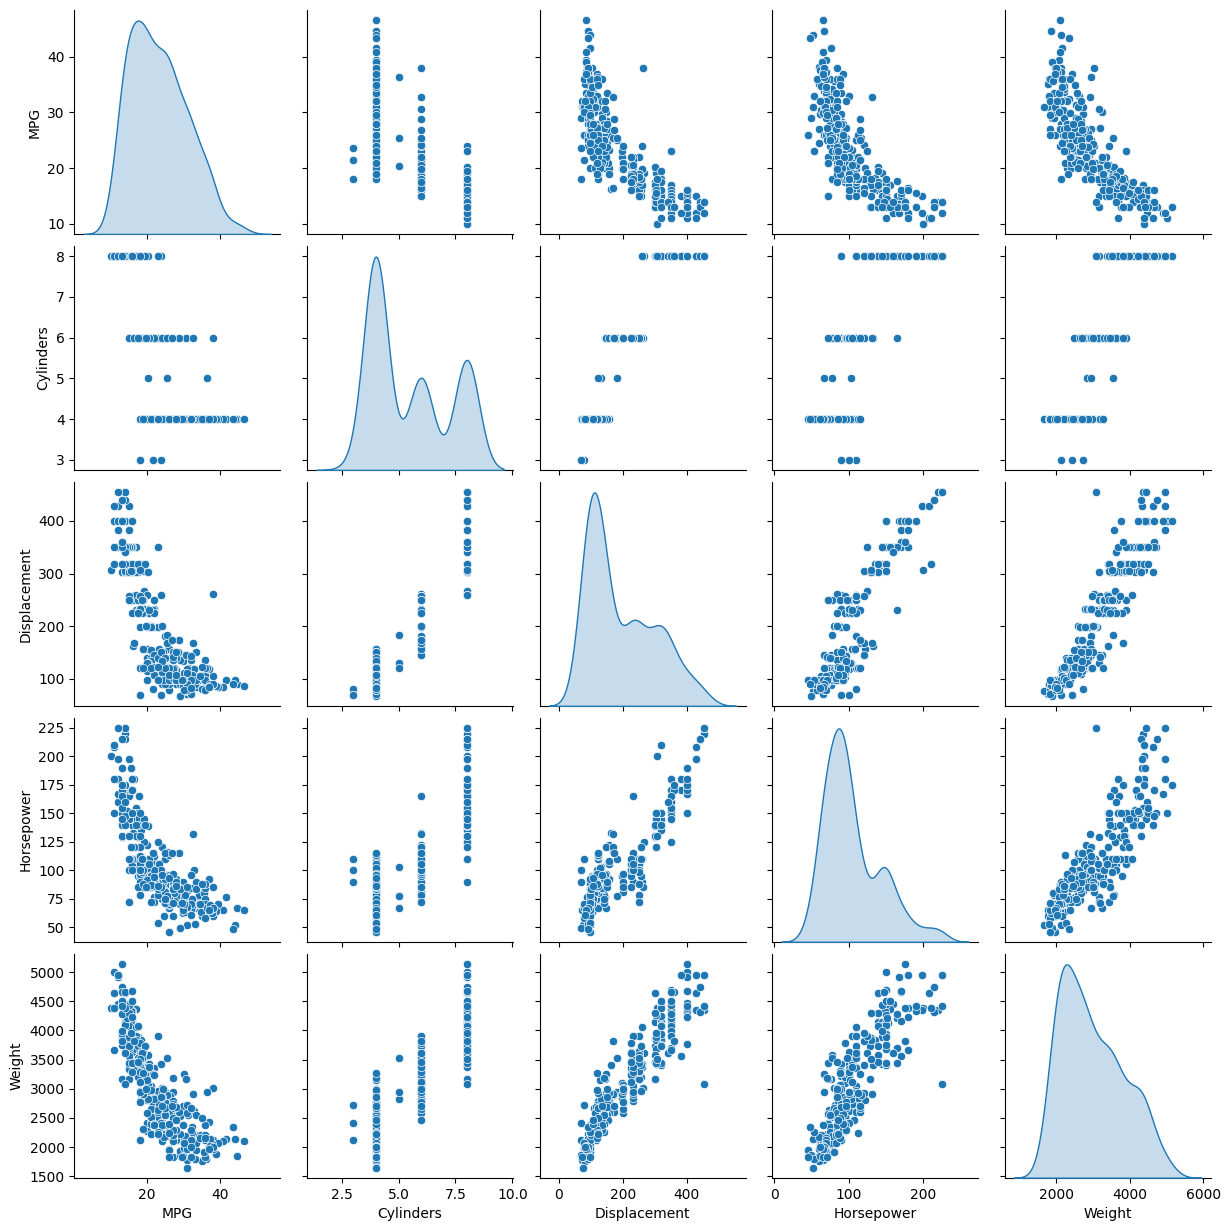

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight']], diag_kind='kde')
#прослеживается обратная зависимость

In [ ]:
#Получим описание признаков, трансформировав вывод представления
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model_Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [ ]:
#Делим датасет на признаки и на то, что будем предсказывать.
#Метод pop('MPG') удаляет столбец MPG из DataFrame и возвращает его содержимое.
train_features=train_dataset.copy()
test_features=test_dataset.copy()

train_labels=train_features.pop('MPG')
test_labels=test_features.pop('MPG')

In [ ]:
#Посчитаем среднее и стандартное отклонение для признаков
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model_Year,75.898089,3.675642


In [ ]:
#Создадим слой нормализации для масштабирования входных данных.
normalizer=tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


Часть 2. Построение линейной модели от количества лошадиных сил Horsepower в автомобиле

In [ ]:
#Создадим переменную horsepower, которая будет содержать массив NumPy со всеми значениями из столбца Horsepower в train_features.
horsepower=np.array(train_features['Horsepower'])


In [ ]:
#Пишем нормалайзер, который адаптируется к кол-ву лошадиных сил
horsepower_normalizer=layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Создаем простую линейную модель
horsepower_model=tf.keras.Sequential([
    # 1 слой - нормалайзер, который нормализует данные
    horsepower_normalizer,
    # 2 слой - полносвязный, в котором кол-во нейронов равно 1
    layers.Dense(units=1)
])

In [ ]:
#Выведем, как выглядит нейронная сеть
horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [ ]:
#Предскажем выход нейронной сети для 10 первых значений
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


array([[-0.36 ],
       [-0.204],
       [ 0.665],
       [-0.505],
       [-0.457],
       [-0.179],
       [-0.541],
       [-0.457],
       [-0.119],
       [-0.204]], dtype=float32)

In [ ]:
#выведем значения, которые мы имеем
train_labels.values[:10]

array([28. , 22.3, 12. , 38. , 33.8, 19.4, 38.1, 30. , 20. , 20. ])

In [ ]:
#компиляция, скорость обучения 0.1. В качестве Loss будем брать среднюю абсолютную ошибку
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
#Запустим обучение: 100 эпох, 20% уходит на тестовую часть
%%time
history=horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=1,
    validation_split=0.2)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 22.6882 - val_loss: 22.9359
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.5970 - val_loss: 22.1357
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20.9114 - val_loss: 21.3361
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.2525 - val_loss: 20.5359
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.4997 - val_loss: 19.7359
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.9420 - val_loss: 18.9360
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18.4533 - val_loss: 18.1359
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.2379 - val_loss: 17.3357
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.2283 - val_loss: 16.5360
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.3824 - val_loss: 15.7361
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.8799 - val_loss: 14.9360
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.3

In [ ]:
#Получим DataFrame hist, который содержит информацию о метриках (loss) на каждой эпохе обучения, а также номер каждой эпохи.
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804979,4.179841,95
96,3.804814,4.210206,96
97,3.805464,4.202503,97
98,3.807144,4.204468,98
99,3.803549,4.168875,99


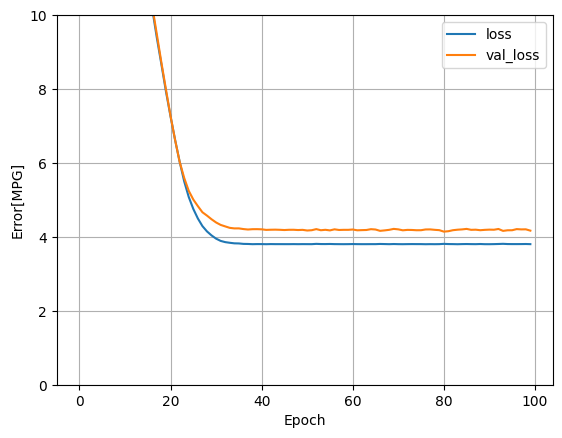

In [ ]:
#Создадим функцию, которая обрисует нам значения loss и val_loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error[MPG]')
  plt.legend()
  plt.grid(True)

#Построим график данной функции
plot_loss(history)

In [ ]:
#Создадим словарь test_results, где  будет храниться результат оценки модели horsepower_model на тестовых данных

test_results={}

test_results['horsepower_model']=horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [ ]:
#Ошибка в тестовой части
test_results

{'horsepower_model': 3.6490674018859863}

In [ ]:
x=tf.linspace(0.0, 250, 251)
y=horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


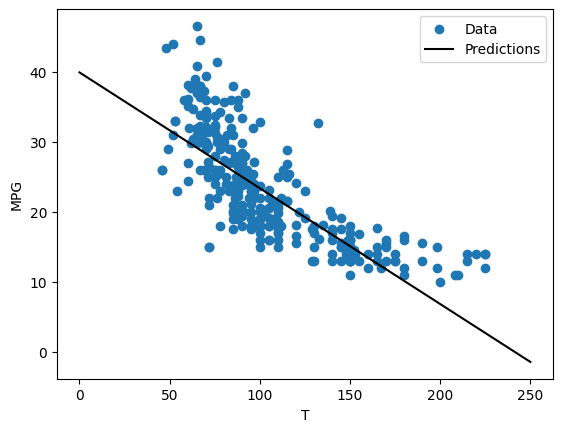

In [ ]:
#Создадим функцию, которая покажет зависимость эффективности автомобиля от признака Horsepower (кол-во лошадиных сил)
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('T')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x, y)
#модель хорошо описывает данные

Часть 3. Построение линейной модели с использованием всех признаков

In [ ]:
#Модифицируем нашу модель. Будем использовать normalizer, который будет использовать все наши признаки
linear_model=tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [ ]:
#Получим предсказание по 10 первым значениям
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


array([[ 0.687],
       [ 1.003],
       [-1.987],
       [ 0.188],
       [ 2.938],
       [-0.216],
       [ 3.138],
       [ 1.027],
       [-0.009],
       [ 3.621]], dtype=float32)

In [ ]:
#Скомпилируем модель
linear_model.layers[1].kernel

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
#Обучим модель
%%time
history=linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=1,
    validation_split=0.2)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 23.4181 - val_loss: 23.0386
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.5500 - val_loss: 22.2935
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 21.8802 - val_loss: 21.5576
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.0097 - val_loss: 20.8593
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.7964 - val_loss: 20.1144
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.9608 - val_loss: 19.4021
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.4237 - val_loss: 18.6361
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.2566 - val_loss: 17.9396
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.1289 - val_loss: 17.1897
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.0963 - val_loss: 16.4807
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.8110 - val_loss: 15.7514
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

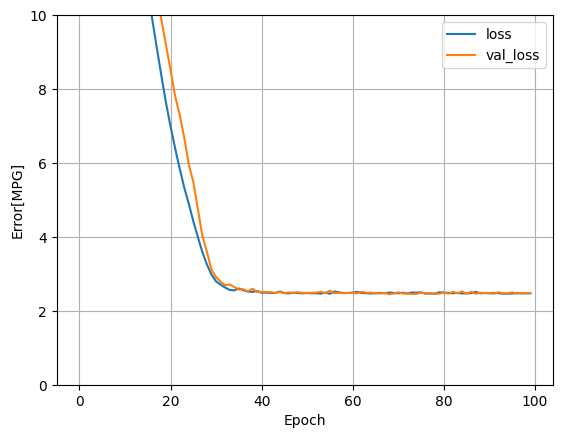

In [ ]:
plot_loss(history)

In [ ]:
#Построим test_results для линейной модели
test_results['linear_model']=linear_model.evaluate(
    test_features, test_labels, verbose=0)

test_results

{'horsepower_model': 3.6490674018859863, 'linear_model': 2.461980104446411}

Часть 4. Построение многослойного персептрона

In [ ]:
#Строим многослойную сеть. Добавляем слои (norm - слой нормализации)
def build_and_compile_model(norm):
  model=keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.optimizers.Adam(0.001))
  return model

In [ ]:
#Компилируем нашу модель
dnn_horsepower_model=build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
#Обучим модель. В качестве признака учтем Horsepower
%%time
history=dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.21 s, sys: 272 ms, total: 7.49 s
Wall time: 7.91 s


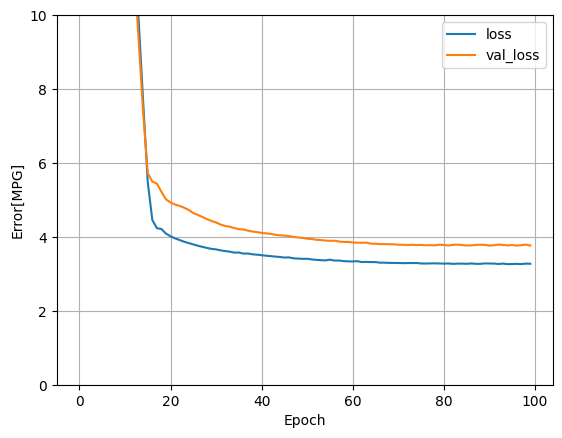

In [ ]:
#Посмотрим, как падала ошибка
plot_loss(history)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


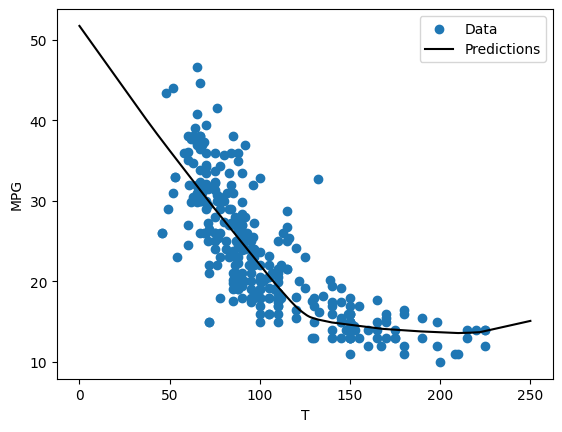

In [ ]:
#Оцените, как модель лучше или хуже описала данные. Как ответите на этот вопрос?
x=tf.linspace(0.0, 250, 251)
y=dnn_horsepower_model.predict(x)
plot_horsepower(x, y)
#линия лучше, чем в модели horsepower, однако ошибка больше

In [ ]:
#Скомпилируем нейонную сеть и выведем информацию о ней.
dnn_model=build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (10, 9)                     │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [ ]:
#Обучим модель на всех данных
%%time
history=dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.79 s, sys: 295 ms, total: 8.09 s
Wall time: 9.11 s


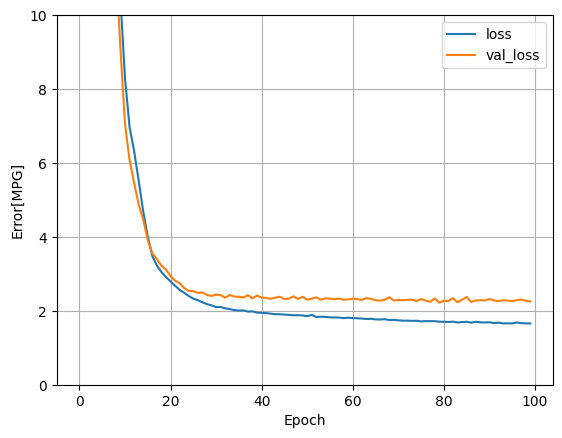

In [ ]:
#Посмотрим поведение ошибки
plot_loss(history)

In [ ]:
#Оценим модель на тестовом наборе данных
test_results['dnn_model']=dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

{'horsepower_model': 3.6490674018859863,
 'linear_model': 2.461980104446411,
 'dnn_horsepower_model': 2.461980104446411,
 'dnn_model': 1.6410573720932007}

Часть 5. Подведем итог

In [ ]:
#Выведем ошибку для каждой модели
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.649067
linear_model,2.461980
dnn_horsepower_model,2.461980
dnn_model,1.641057


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


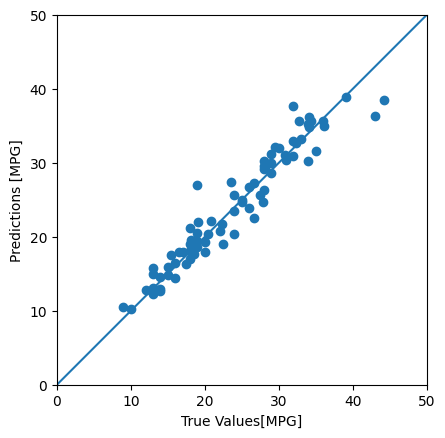

In [ ]:
test_predictions=dnn_model.predict(test_features).flatten()

a=plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values[MPG]')
plt.ylabel('Predictions [MPG]')
lims=[0, 50]
plt.xlim(lims)
plt.ylim(lims)
y=plt.plot(lims, lims)

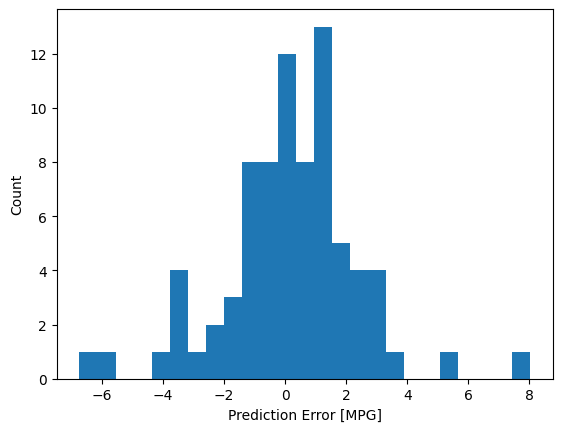

In [ ]:
#Строим гистограмму распределений ошибок.:
error=test_predictions-test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_=plt.ylabel('Count')